#Proyecto Reduccion, Selección, Clustering y Clasificación

El presente proyecto consiste en 3 partes. La primera parte consiste en generar mediante técnicas de clustering, los grupos que mejor representen el problema en cuestión. 
Luego debera aplicar técnicas de clasificación binaria y reduccion de dimensiones (PCA).
El conjunto de datos se encuentra en https://archive.ics.uci.edu/ml/datasets/HTRU2 

Ingrese al link si quiere saber más sobre el conjunto de datos.
<fo
### Descripción del Dataset

El set de datos corresponde a observaciones astronómicas de candidatos a [pulsar](https://astronomy.swin.edu.au/cosmos/p/pulsar), un tipo raro de estrella de neutrones que emite radiación periódica que se detecta mediante radiotelescopios.  A través de los patrones de emisión es posible identificar candidatos a pulsar, sin embargo, muchas veces estos patrones son alterados  por la interferencia de radiofrecuencia (RFI) o ruido.

El set de datos con que trabajaremos corresponde a HTRUS (High Time Resolution Universe Survey) de la Universidad de Manchester.  Las primeras 8 columnas son las características del dataset, que corresponden a la trayectoría de emisión; las 4 primeras variables son estadísticas simples, y las cuatro siguientes están ajustadas. La última columna es la clase correspondiente a la clasificación real de pulsar(1) o de ruido(0):

    1. Mean of the integrated profile.
	2. Standard deviation of the integrated profile.
	3. Excess kurtosis of the integrated profile.
	4. Skewness of the integrated profile.
	5. Mean of the DM-SNR curve.
	6. Standard deviation of the DM-SNR curve.
	7. Excess kurtosis of the DM-SNR curve.
	8. Skewness of the DM-SNR curve.
    9. Target

La mayor parte de los registros corresponden a ruido, y solo el 9% de los registros corresponde a pulsar.


### 1. Clustering

Primero se realizara el proceso de clustering con las características de los datos, ocupando una técnica de clustering. 

Tambien se hara un reporte de las medidas de desempeño Silhouette, Homogeneity y Completeness.

In [ ]:
# Importamos los datos necesarios para el proyecto
import requests
import zipfile

# Descargar zip
url = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip')
open('HTRU2.zip', 'wb').write(url.content)

# Listar archivos del zip
z = zipfile.ZipFile('HTRU2.zip',"r" )
print(z.namelist() )

# Descomprimir cvs
z.extract('HTRU_2.csv')  
z.close()

['HTRU_2.csv', 'HTRU_2.arff', 'Readme.txt']


In [ ]:
# Importamos pandas
import pandas as pd

# Establecemos los nombres de las columnas
col_names = ["Media_perfil"
            ,"Desvest_perfil"
            ,"Exceso_curtosis_perfil"
            ,"Asimetria_perfil_integrado"
            ,"Media_curva_DM_SNR"
            ,"Desvest_curva_DM_SNR"
            ,"Exceso_curtosis_curva_DM_SNR"
            ,"Asimetria_curva_DM_SNR"
            ,"Clase"]

# Creamos un DataFrame con los datos importados, y seleccionamos header=None debido a que los datos no tienen cabecera
df= pd.read_csv("HTRU_2.csv", header=None, names=col_names)

In [ ]:
#Exploramos los datos
df.head()

,Media_perfil,Desvest_perfil,Exceso_curtosis_perfil,Asimetria_perfil_integrado,Media_curva_DM_SNR,Desvest_curva_DM_SNR,Exceso_curtosis_curva_DM_SNR,Asimetria_curva_DM_SNR,Clase
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [ ]:
# Observamos los valores distintos de la columna target 'Clase' para tener un referencia del modelamiento
df['Clase'].unique()

array([0, 1])

In [ ]:
# Realizamos una descripción de datos
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Media_perfil,17898.0,111.079968,25.652935,5.812500,100.929688,115.078125,127.085938,192.617188
Desvest_perfil,17898.0,46.549532,6.843189,24.772042,42.376018,46.947479,51.023202,98.778911
Exceso_curtosis_perfil,17898.0,0.477857,1.064040,-1.876011,0.027098,0.223240,0.473325,8.069522
Asimetria_perfil_integrado,17898.0,1.770279,6.167913,-1.791886,-0.188572,0.198710,0.927783,68.101622
Media_curva_DM_SNR,17898.0,12.614400,29.472897,0.213211,1.923077,2.801839,5.464256,223.392140
Desvest_curva_DM_SNR,17898.0,26.326515,19.470572,7.370432,14.437332,18.461316,28.428104,110.642211
Exceso_curtosis_curva_DM_SNR,17898.0,8.303556,4.506092,-3.139270,5.781506,8.433515,10.702959,34.539844
Asimetria_curva_DM_SNR,17898.0,104.857709,106.514540,-1.976976,34.960504,83.064556,139.309331,1191.000837
Clase,17898.0,0.091574,0.288432,0.000000,0.000000,0.000000,0.000000,1.000000


##### Observaciones:
* Se puede apreciar que los datos no poseen datos nulos. 
* Se puede observar que los datos fluctuan en el dominio de los reales y no están estandarizados.
* Se observa que hay diferencias sustanciales en magnitud de los datos por lo que será necesario estandarizar, para efectos de un modelo de clustering que utiliza medidas de distancias en los datos.



##### DataWrangling:

In [ ]:
# Librerías necesarias para el proyecto
from IPython.display import display
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Statsmodels
import statsmodels.api as st 
import matplotlib.cm as cm

In [ ]:
# Excluimos del análisis la columna target 'Clase'
df_cluster = df.drop(['Clase'],axis=1)
y = df['Clase']
print(df_cluster.shape)
y.head()

(17898, 8)


0    0
1    0
2    0
3    0
4    0
Name: Clase, dtype: int64

In [ ]:
# Estandarizamos el valor de los datos para poder utilizarlos en el cluster
df_cluster_scaler = StandardScaler().fit_transform(df_cluster.values)

In [ ]:
# Definimos un modelo K-means
kmeans = KMeans(n_clusters=2, #Nº cluster en base a la variabilidad de la columna 'Clase'
                n_init=100, #Nº de iteraciones
                init='k-means++', #Selecciona el punto de inicio de modo inteligente para encontrar más rápido coincidencias
                tol=1e-10, #Parametro que límite donde converge
                random_state=170,
                verbose=False) #No mostrar que hace

# Ajustamos el modelo a los datos
kmeans.fit(df_cluster_scaler)
# Predicciones y los centros de los clusters (centroides).
display(kmeans.labels_)
display(kmeans.cluster_centers_)

array([1, 1, 1, ..., 1, 1, 0], dtype=int32)

array([[-1.43811479, -0.5818564 ,  1.80773499,  1.68908335,  2.22036767,
         2.2169289 , -1.62334806, -0.96080008],
       [ 0.1867434 ,  0.07555575, -0.23473966, -0.21933239, -0.28832121,
        -0.28787468,  0.21079647,  0.12476269]])

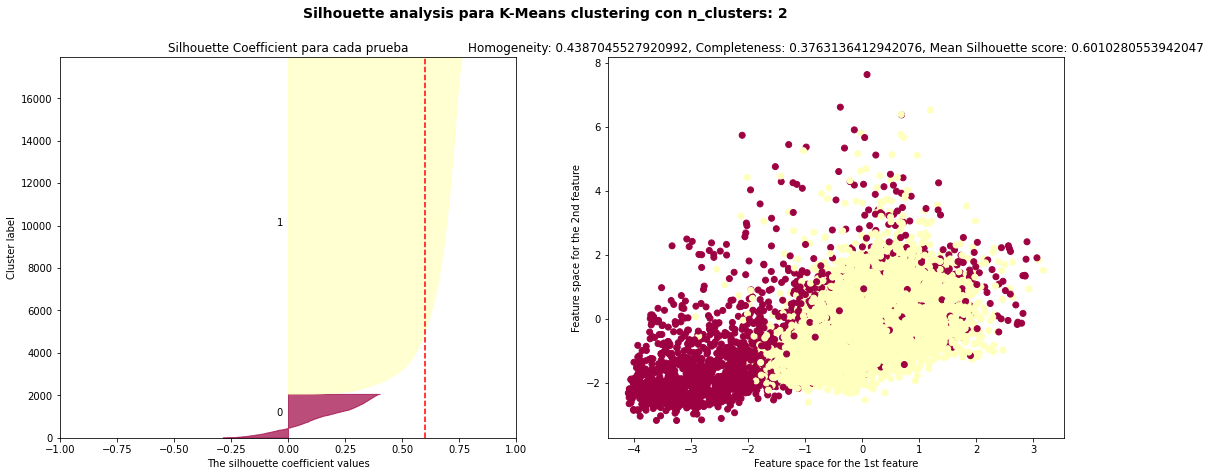

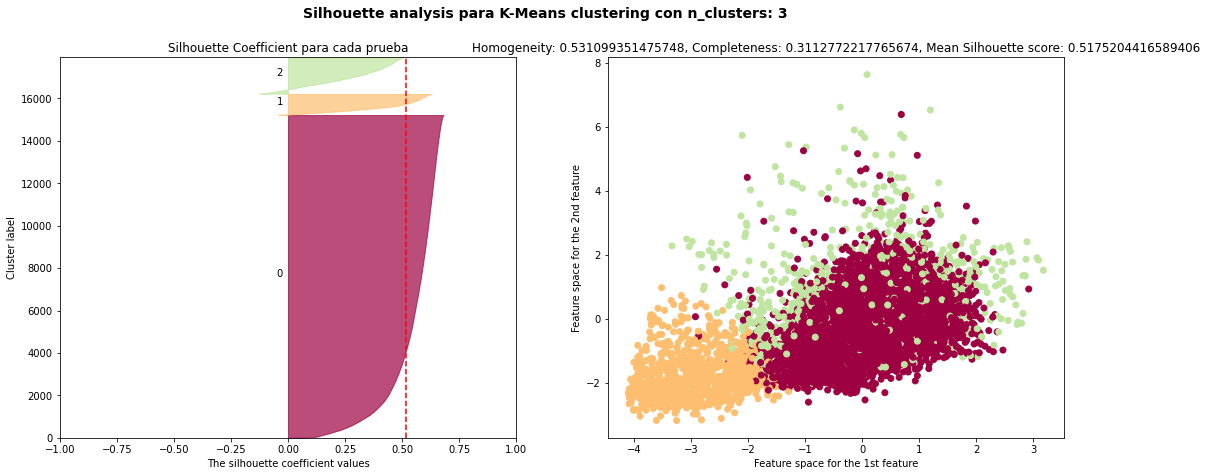

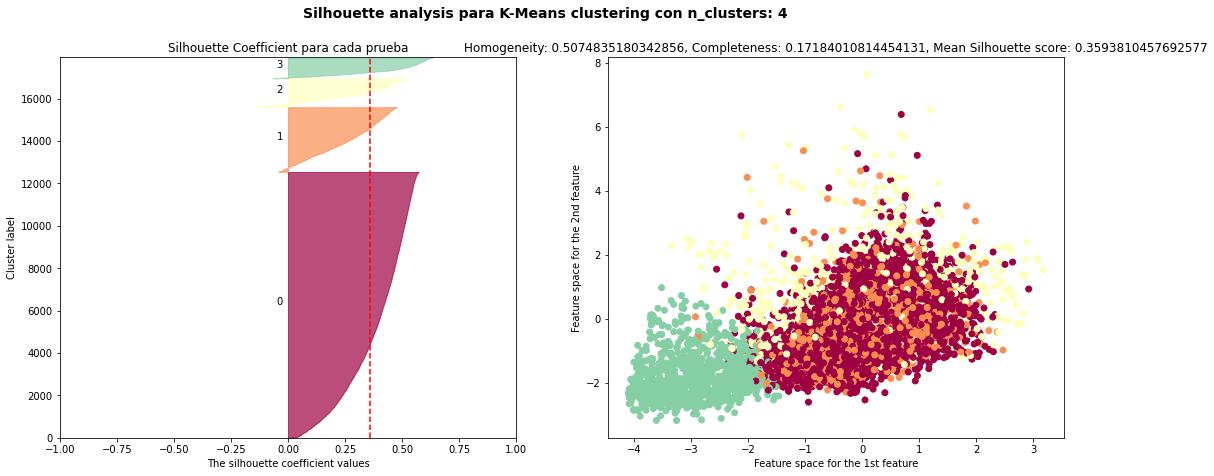

In [ ]:
# Lista con el número de clusters a probar.
range_n_clusters = [2, 3, 4]

# Para cada cluster, realizamos el análisis de Silhouette y visualizamos los resultados.
for n_clusters in range_n_clusters:
    
    # Entrenar K-means.
    kmeans = KMeans(n_clusters=n_clusters, random_state=10,init='k-means++', max_iter=300)
    y_pred = kmeans.fit_predict(df_cluster_scaler)
    
    # Calcular la homogeneity y el completeness.
    homogeneity = metrics.homogeneity_score(y, y_pred)
    completeness = metrics.completeness_score(y, y_pred)
    
    # Calcular el Silhouette Coefficient para cada ejemplo.
    s = metrics.silhouette_samples(df_cluster_scaler, y_pred)
    
    # Calcular el Silhouette Coefficient promedio para todos los puntos.
    s_mean = metrics.silhouette_score(df_cluster_scaler, y_pred)
    
    # Gráficos -----------------------------------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Configure plot.
    plt.suptitle('Silhouette analysis para K-Means clustering con n_clusters: {}'.format(n_clusters),
                 fontsize=14, fontweight='bold')
    
    # Configure 1st subplot.
    ax1.set_title('Silhouette Coefficient para cada prueba')
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(df_cluster_scaler) + (n_clusters + 1) * 10])
    
    # Configure 2st subplot.
    ax2.set_title('Homogeneity: {}, Completeness: {}, Mean Silhouette score: {}'.format(homogeneity,
                                                                                        completeness,
                                                                                        s_mean))
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    # For 1st subplot ------------------------------------------------------------------------------------------
    
    # Plot Silhouette Coefficient for each sample
    y_lower = 10
    for i in range(n_clusters):
        ith_s = s[y_pred == i]
        ith_s.sort()
        size_cluster_i = ith_s.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_s,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
        
    # Plot the mean Silhouette Coefficient using red vertical dash line.
    ax1.axvline(x=s_mean, color="red", linestyle="--")
    
    # For 2st subplot -------------------------------------------------------------------------------------------
    
    # Plot the predictions
    colors = cm.Spectral(y_pred.astype(float) / n_clusters)
    ax2.scatter(df_cluster_scaler[:,0], df_cluster_scaler[:,1], c=colors)

##### Conclusiones: 
* Se aplicó como prueba el algoritmo K-Means para 2, 3 y 4 clusters distintos
* Se puede apreciar que los valores de los indicadores de desempeño para el modelo K-means son relativamente bajos. Osea K-means quisa no sea el algoritmo mas apropiado.
* La agrupación de 2 cluster  tiene mejor desempeño en silueta y completitud, lo que era esperado deacuerdo a la clasificación binaria de la clase. Sin embargo tiene menor homogenidad que los algoritmos de 3 y 4 cluster. 
* Tiene un coeficiente de silueta de 0.6, por lo que el modelo alcanza a clusterizar correctamente el 60% de los datos dentro de su cluster, en mayor medida aquellos valores que son clasificados en 1.
* Con respecto a la homogeneidad es de 0.43, lo que se infiere que el conjunto de datos no es muy compacto y debido a su dispersión no es posible agrupar con mucha eficacia.
* Por último, el indicador de completitud es de 0.3768, esto hace suponer que es complicado para el modelo poder encasillar la totalidad de los datos en su cluster predicho, solo pudiendo ubicar dentro del cluster un 37.68% de las predicciones.


### 2. Clasificación

Evaluaremos 2 algorítmos de clasificación y evaluaremos su desempeño. También se utilizara un reporte de clasificación.





#### 2.1 Clasificación con Random Forest

In [ ]:
# Importamos un random forest predeterminado
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Generamos un split de datos de entrenamiento y prueba
df_vars = df.drop(['Clase'],axis=1)
df_target = df['Clase']
# Se crear 2 DataFrame con los datos para poder realizar un split de datos
# Se ejecuta el splot
X_train, X_test, y_train, y_test = train_test_split(df_vars, df_target, test_size=0.2)

In [ ]:
# Creamos un objeto de random forest con 100 árboles
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train);

##### Resultados con F1 score:

In [ ]:
# Importamos la librería de mediciones y reporte para el modelo
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)

print(f1_score(y_test, y_pred, average=None))
print(f1_score(y_test, y_pred, average='binary'))

[0.9911152  0.90822785]
0.9082278481012659


*   El valor de F1 para nuestro modelo de Random Forest es de 0,91. F1 es una buena métrica para comparar el desempeño de 2 modelos, ya que considera la presición y recall. 

#### 2.2 Clasificacion con Regresión Logística

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [ ]:
X = df.iloc[:, :2].values  # usaremos solo 2 caracteristicas
y = df['Clase'].values

In [ ]:
def plot_decision_boundary(X, y, regression):
    # Gráfico de los límites de decisión. Para eso, asignaremos un color a cada
    # punto en la malla [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02  # tamaño de paso en la malla
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = regression.predict(np.c_[xx.ravel(), yy.ravel()])

    # Poner el resultado en un gráfico de color
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plotear los puntos de entrenamiento
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('Media_perfil')
    plt.ylabel('Desvest_perfil')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()

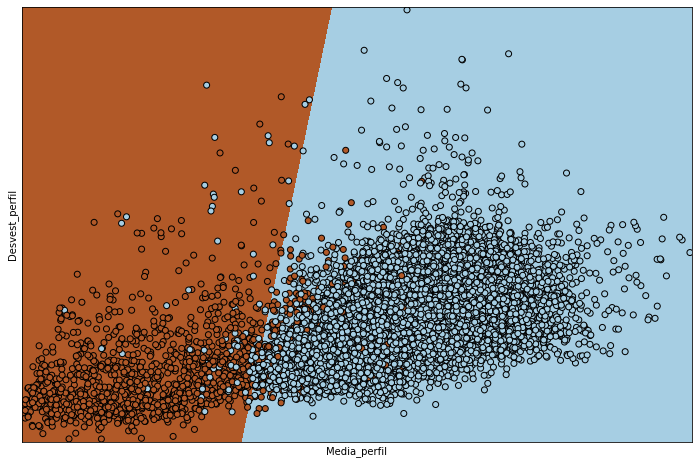

In [ ]:
# Crear una instancia de clasificador de regresión logística
logreg = LogisticRegression().fit(X, y)
plt.figure(figsize=(12,8))
plot_decision_boundary(X, y, logreg)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred=logreg.predict(X_test)

##### Resultados con F1 score:

In [ ]:
print(f1_score(y_test, y_pred, average=None))
print(f1_score(y_test, y_pred, average='binary'))

[0.98286581 0.8       ]
0.8


*   El valor de F1 para nuestro modelo de Regresión logística es de 0,8

##### Evaluación de métricas de Matriz de Confusión de la Reg. Logística:

In [ ]:
# importamos metrics
from sklearn import metrics

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[3241,   18],
       [  95,  226]])

Text(0.5, 257.44, 'Predicted label')

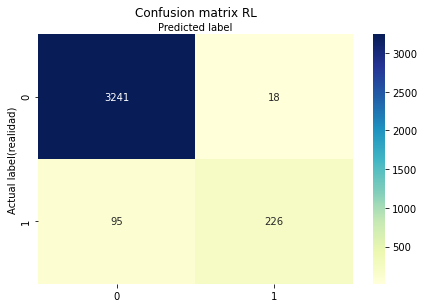

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix RL', y=1.1)
plt.ylabel('Actual label(realidad)')
plt.xlabel('Predicted label')


En la matriz de confusión podemos observar que tenemos:  
-Verdaderos Negativos (TN): 3241  
-Falsos Negativos (FN): 95  
-Verdaderos Positivos (TP): 226  
-Falsos Positivos (FP): 18  


Ahora calcularemos sus métricas





In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9684357541899441
Precision: 0.9262295081967213
Recall: 0.7040498442367601


##### Conclusiones:
En la regresión logÍstica obtuvimos una tasa de clasificación **Accuracy** del 96,8%, lo que indica que se predijo una alta cantidad de clases correctamante. Sin embargo esta métrica no sería apropiada para nuestra data, ya que las clases están desbalanceadas, ya que la mayoría de las clases son negativas (ruido).


El modelo tiene una **precisión** del 92,6%, considerado como una buena frecuencia de precisión. 

Sin embargo **Recall =** $\frac{TP}{TP+FN}$ es de solo 0,70, lo  que indica que solo un 70% de los pulsar positivos se predijo correctamente. O sea hay una tendencia a subestimar valores positivos.


Métrica AUC

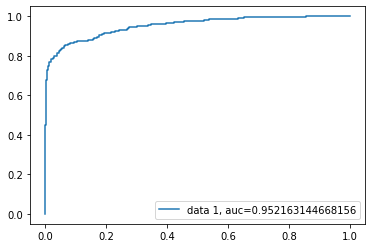

In [ ]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


La puntuación del área bajo la curva AUC para el modelo de regresión logística es 0,94. Considerada alta. Donde una puntuación AUC de valor 1 representa un clasificador perfecto y 0,5 representa un clasificador sin valor.

#### Conclusiones del punto 2:  
Al comparar los 2 algoritmos de clasificación propuestos (2.1 Clasificación con Random Forest y 2.2 Clasificacion con Regresión Logística), podemos concluir que: 

*   Para evaluar que algoritmo de clasificación tiene un mayor desempeño, comparamos las métricas de F1 score, que se basan en la presición y recall del modelo. 
*   La métrica Accuracy no es adecuada para comparar ambos modelos, ya que las 
clases (pulsar y ruido) están desbalanceadas. 

*   Para evaluar que algoritmo de clasificación tiene un mayor desempeño, comparamos las métricas de F1 score, que se basan en la presición y recall del modelo.
*   El valor de F1 del modelo de Random Forest es de 0,91 y valor f1 de la Regresión Logística es de 0,8, or lo cual el modelo Randon Forest tiene un mejor desempeño para clasificar pulsar y ruido.







### 3. Reducción de Dimensionalidad

Con los mismos algoritmos de clasificación anteriormente usados, se utilizara PCA para reducir las dimensiones del problema.

In [ ]:
# Importamos librerías necesarias y separamos las columnas de las variables
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np
from sklearn.ensemble import RandomForestClassifier

df_col= df.drop(['Clase'],axis=1)   #Almaceno las columnas
df_y = df['Clase']                  #Almaceno la variable explicada

print(df_col.keys())                                                  #Visualizo la información de las variables
print(df_col.shape)     

Index(['Media_perfil', 'Desvest_perfil', 'Exceso_curtosis_perfil',
       'Asimetria_perfil_integrado', 'Media_curva_DM_SNR',
       'Desvest_curva_DM_SNR', 'Exceso_curtosis_curva_DM_SNR',
       'Asimetria_curva_DM_SNR'],
      dtype='object')
(17898, 8)


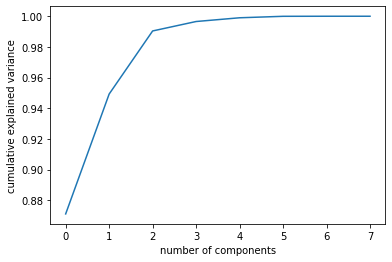

In [ ]:
#Para definir las dimensiones del PCA visualizamos la varianza acumulada
pca = PCA().fit(df_col)
plt.plot(np.cumsum(pca.explained_variance_ratio_))  #Graficamos la varianza explicada de las variables
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
#Defino las dimensiones necesarias cuando obtengo una varianza acumulada de a lo menos que 80%
pos_80 = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.8)
print(np.cumsum(pca.explained_variance_ratio_)[pos_80])             #Con un 80% no hay componentes
print(pos_80)

0.8710530410334033
0


In [ ]:
#Estandarizamos la data y pruebo con un modelo PCA con dos componentes para visualizar el resultado que entrega
df_col_std = StandardScaler().fit_transform(df_col)         #Escalamos la data
pca = PCA(2)                                                #Proyectamos de 8 a 2 dimensión
df_projected = pca.fit_transform(df_col)                    #Ajustamos la data estandarizada
print(df_col.shape)
print(df_projected.shape)

(17898, 8)
(17898, 2)


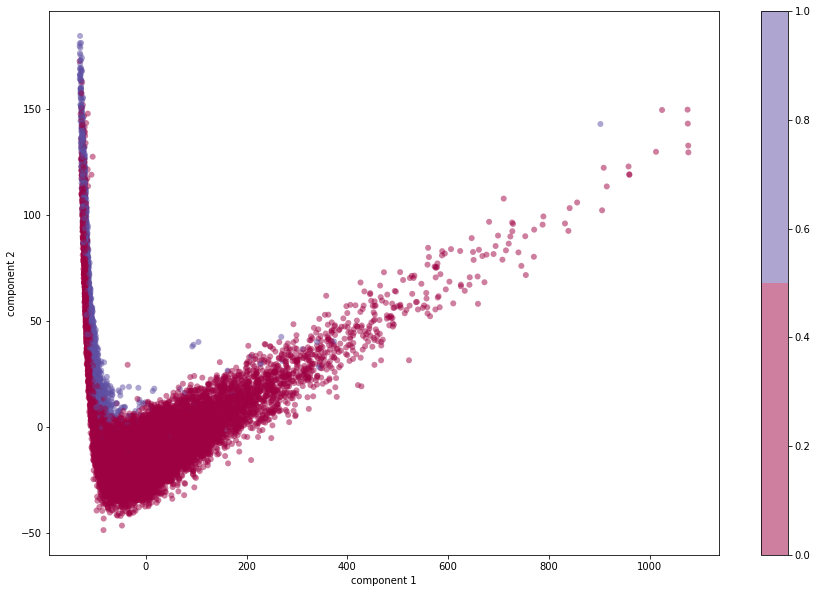

In [ ]:
#Graficamos con dos componentes
plt.figure(figsize=(15,10))
plt.scatter(df_projected[:, 0], df_projected[:, 1],
            c=df_y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Comentarios: En el gráfico anterior no se ve una clara definición de cuándo una observación corresponde a un pulsar y cuándo no. Existe una zona donde predominan los registros que corresponden a ruido.

Según lo que se visualiza, la metodología PCA no sería un buen acertamiento para obtener un buen modelo.

####3.1. Random Forest con PCA

In [ ]:
# Generamos un split de datos de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(df_col, df_y, test_size=0.2)

In [ ]:
#Estandarizamos la data
std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
X_test_scaled = std.transform(X_test)
y_train = np.array(y_train)

In [ ]:
#Creamos el modelo con la data estandarizada
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

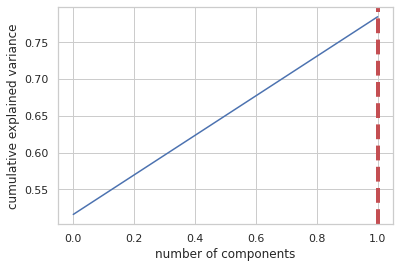

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.516036,0.516036
1,0.784847,0.268810


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

pca_test = PCA(n_components=2)
pca_test.fit(X_train_scaled)

sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=1, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [ ]:
pca = PCA(n_components=1)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
model_PCA = RandomForestClassifier()
model_PCA.fit(X_train_scaled_pca, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

##### Resultados con F1 score

In [ ]:

print(f1_score(y_test, y_pred, average=None))

0.48521643167418826
0.8488826815642458
0.8388513426673118
[0.91789346 0.0525394 ]


##### Conclusiones
Visualizamos que el modelo random forest empeoró con la utilización de PCA con una compomente. Lo cual tiene sentido si según metodología PCA sólo habría que mantener una de las ocho dimensiones de la data.

#### 3.2 Regresión Logística con PCA

In [ ]:
# Generamos nuevamente un split de datos de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(df_col, df_y, test_size=0.2)

In [ ]:
#Aplicamos el método PCA con un componente
pca = PCA(n_components=1)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
#Creamos modelo Regresión logística
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()   #.fit(df_col, y_train)
logreg.fit(X_train_pca,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#Generamos la predicción
y_pred_pca=logreg.predict(X_test_pca)

##### Resultados con F1 score

In [ ]:


print(f1_score(y_test, y_pred_pca, average=None))

0.5223662680931404
0.9111731843575419
0.8738573502888223
[0.95330396 0.09142857]


##### Conclusiones 
Al igual que en el caso anterior, podemos visualizar que PCA no ayuda para obtener un mejor modelo con la data disponible.